<div
    style='background-image: url("images/_banner_.jpg"); padding: 0px;
    background-size: cover; border-radius: 10px; height: 250px;
    background-position: 50% 50%'>
    <div
        style="float: left; margin: 20px; padding: 10px;
        background: rgba(255 , 255 , 255 , 0.8); width: 40%; height: 100px;
        border-radius: 10px">
        <div
            style="position: relative; top: 50%;
            transform: translatey(-50%)">
            <div
                style="font-size: xx-large; font-weight: 900;
                color: rgba(0 , 0 , 0 , 0.9);
                line-height: 100%">Python Workshop
            </div>
            <div
                style="font-size: large; padding-top: 20px;
                color: rgba(0 , 0 , 0 , 0.7)">Summarizing exercise
            </div>
        </div>
    </div>
    <div style="float: right; font-size: small;
        position: relative; top: 90%; padding: 5px;
        background: rgba(255 , 255 , 255 , 0.6); border-top-left-radius: 10px;
        color: rgba(0 , 0 , 0 , 1)">Shahar Shani-Kadmiel, CiTG, TU Delft
    </div>
</div>

## Wrapping it all up

We will now put all the pieces together into a working, reusable workflow.

In [1]:
# some inports that we are going to need
%matplotlib inline
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import obspy
import os

Beam-forming is a process in which array waveform data is steered so that the best beam is resolved. In this process, the back-azimuth and apparent velocity are retrieved as well.

The data in `'data/IM.I53US.jtdfd'` contains results from such a process along with some metadata in the header of the file, documenting the configuration used for the algorithm and some extended information. The structure of the file is as follows:

* A header with ***l*** lines, each starting with a `'#'` character
* A data section with ***m*** line and ***n*** columns

The data section of this file can be read with `numpy.loadtxt`. In this exercise we are only interested in the first 4 columns:

* time, s
* Fisher ratio
* back-azimuth, °
* apparent velocity, m/s

---
### Step 1

Load the data section as 4 vectors into `time`, `fratio`, `baz`, and `app_vel` variables:

In [2]:
# your code here: 1 line
time, fratio, baz, app_vel = np.loadtxt('data/IM.I53US.jtdfd', usecols=range(4)).T

### Step 2

Write a line parser to extract the name and values of each header line. Try to make it flexible so that numbers that should be converted to `float`s are taken care of.

In [3]:
# here are three different lines to consider:
line1 = '# distance = 984.9975957679702'
line2 = '# station = (64.866929, -147.85810087500002, 175.0625)'
line3 = '# bestbeam = IM.I53US.BB.sac'

def line_parser(line):
    # your code here: (approx 8 lines)
    key, value = [item.strip('# ') for item in line.split('=')]
    try:  # convert single float value
        value = float(value)
    except ValueError:  # convert multiple float values
        try:
            value = [float(item.strip('() ')) for item in value.split(',')]
        except ValueError:  # leave as tring
            pass
    # end your code
    return key, value

for line in (line1, line2, line3):
    print(line_parser(line))

('distance', 984.9975957679702)
('station', [64.866929, -147.85810087500002, 175.0625])
('bestbeam', 'IM.I53US.BB.sac')


### Step 3

Think of a data structure that will hold the header and data sections together inside one object. As mentioned earlier, a *dictionary* is a good start but we are going to want to add some plotting functionality so designing our own *class*  is a better choice.

Use the structure below to populate it with the header info and data columns.

1. Start by adjusting the `line_parser` function to be a *private class method*.

Private class methods have a leading underscore (`'_'`) in their name. This is to tell the user that it should not be used directly but rather called by a public method.

**Remember** that methods (functions attached to objects) have the `self` keyword as the first argument.

2. Next, add code to the `__init__` to populate the class:

The code should read the header part of the file and extract the header information, using the `line_parser` method and populate the `self.time`, `self.fratio`, `self.baz`, and `self.app_vel` attributes of the class.

**Remember:** There are ***l*** (unknown) line of header. However, it is known that each header line starts with a `'#'` character and they are all at the top of the file.

In [4]:
class BestBeam():
    """
    Class to handle beamforming results.
    """
    
    def __init__(self, filename):
        """
        Constructor of the object.
        
        Parameters
        ----------
        filename : str
            Path (relative or absolute) to the filename.
        """
        
        self.filename = filename
        
        # **Part 2:** your code here: (approx 8 lines)
        with open(filename) as f:
            for line in f:
                line = line.strip()  # get rid of whitespace at start and end
                if line.startswith('#'):
                    self._line_parser(line)
                else:
                    break
                    
        self.time, self.fratio, self.baz, self.app_vel = np.loadtxt(
            filename, usecols=range(4)).T
        # end of part 2
        
    def _line_parser(self, line):
        # **Part 1:** your code here: (approx 9 lines)
        key, value = [item.strip('# ') for item in line.split('=')]
        try:  # convert single float value
            value = float(value)
        except ValueError:  # convert multiple float values
            try:
                value = [float(item.strip('() ')) for item in value.split(',')]
            except ValueError:  # leave as tring
                pass

        vars(self)[key] = value
        # end of part 1
        
BestBeam('data/IM.I53US.jtdfd')

In [5]:
bb = BestBeam('data/IM.I53US.jtdfd')
bb

### Step 4

Read the best beam:

The best beam is a SAC file containing the waveform retrieved in the beam-forming process. There is a comprehensive toolkit for handling waveform data, [ObsPy](https://github.com/obspy/obspy/wiki). If you work with waveform data, this is the package for you.

Reading waveform data with ObsPy is as simple as [`obspy.read()`](http://docs.obspy.org/packages/autogen/obspy.core.stream.read.html#obspy.core.stream.read). 

1 Trace(s) in Stream:
.BESTBEAM..M | 2018-01-23T09:26:41.000000Z - 2018-01-23T10:46:41.000000Z | 20.0 Hz, 96001 samples


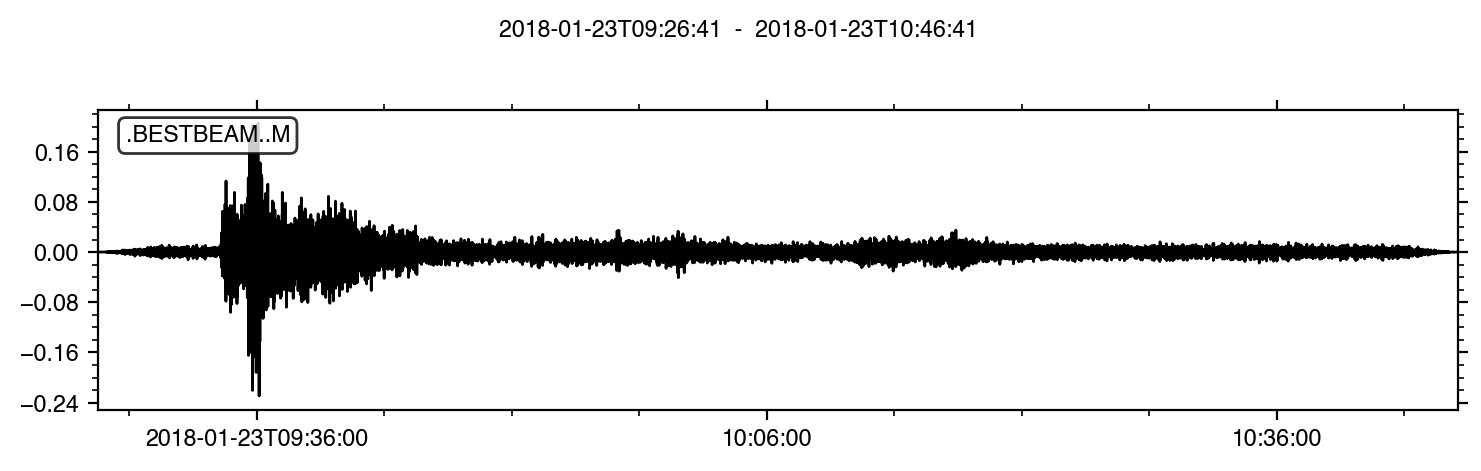

In [6]:
bb_wf = obspy.read('data/IM.I53US.BB.sac')
print(bb_wf)
bb_wf.plot()

But it would be nice if this waveform data was also part of the class:

Note that the header contained information about the *bestbeam* file. The only thing is that this file location is relative to the location of the output file we pass to the `BestBeam` class.

In [7]:
print(bb.bestbeam)
obspy.read(bb.bestbeam)

IM.I53US.BB.sac


FileNotFoundError: [Errno 2] No such file or directory: 'IM.I53US.BB.sac'

We need to follow the path from the location of the output file:

In [8]:
# if out outfile is:
filename = 'data/IM.I53US.jtdfd'

# we can split it to a ``path`` part and a ``file`` part:
path, file = os.path.split(filename)
print(path, file)

# we can check if the ``bestbeam`` file exists in that path:
print(os.path.exists(os.path.join(path, bb.bestbeam)))

# or even list the contents of that path:
os.listdir(path)

data IM.I53US.jtdfd
True


['.DS_Store',
 'berkeley.sw4',
 'IM.I53US.BB.sac',
 'IM.I53US.jtdfd',
 'SURE_GI_JettedBlock_20171027_135204.txt']

Let's use that to read the best beam as part of the `__init__`.

In [9]:
class BestBeam():
    """
    Class to handle beamforming results.
    """
    
    def __init__(self, filename):
        """
        Constructor of the object.
        
        Parameters
        ----------
        filename : str
            Path (relative or absolute) to the filename.
        """
        
        self.filename = filename
        self.path, self.file = os.path.split(filename)  # get the relative path
        with open(filename) as f:
            for line in f:
                line = line.strip()  # get rid of whitespace at start and end
                if line.startswith('#'):
                    self._line_parser(line)
                else:
                    break
                    
        self.time, self.fratio, self.baz, self.app_vel = np.loadtxt(
            filename, usecols=range(4)).T
        
        # your code here: (1 line)
        self.bb_wf = obspy.read(os.path.join(self.path, self.bestbeam))[0]
        
    def _line_parser(self, line):
        key, value = [item.strip('# ') for item in line.split('=')]
        try:  # convert single float value
            value = float(value)
        except ValueError:  # convert multiple float values
            try:
                value = [float(item.strip('() ')) for item in value.split(',')]
            except ValueError:  # leave as tring
                pass

        vars(self)[key] = value

In [10]:
bb = BestBeam('data/IM.I53US.jtdfd')
bb.bb_wf

.BESTBEAM..M | 2018-01-23T09:26:41.000000Z - 2018-01-23T10:46:41.000000Z | 20.0 Hz, 96001 samples

**That is it**, in terms of data population of the structure we are done. We can now access the data in the class and use it for visualization. It would be nice, however, to add this functionality as a *class method*.

---

### Step 5

1. Write a class method to plot the best beam, back-azimuth, apparent velocity and Fisher ratio as a function of time in separate row panels.

2. Write a class method to plot the source and station on a map.

In [11]:
class BestBeam():
    """
    Class to handle beamforming results.
    """
    
    def __init__(self, filename):
        """
        Constructor of the object.
        
        Parameters
        ----------
        filename : str
            Path (relative or absolute) to the filename.
        """
        
        self.filename = filename
        self.path, self.file = os.path.split(filename)  # get the relative path
        with open(filename) as f:
            for line in f:
                line = line.strip()  # get rid of whitespace at start and end
                if line.startswith('#'):
                    self._line_parser(line)
                else:
                    break
                    
        self.time, self.fratio, self.baz, self.app_vel = np.loadtxt(
            filename, usecols=range(4)).T
        
        self.bb_wf = obspy.read(os.path.join(self.path, self.bestbeam))[0]
        
    def _line_parser(self, line):
        key, value = [item.strip('# ') for item in line.split('=')]
        try:  # convert single float value
            value = float(value)
        except ValueError:  # convert multiple float values
            try:
                value = [float(item.strip('() ')) for item in value.split(',')]
            except ValueError:  # leave as tring
                pass

        vars(self)[key] = value
        
    def plot_data(self, sort_by='fratio', s=5, cmap='inferno_r',
                  **kwargs):
        
        # your code here: (approx 12 lines)
        sort_idx = vars(self)[sort_by].argsort()
        
        fig, ax = plt.subplots(4, sharex=True, figsize=(7, 7))
        ax[0].plot(self.bb_wf.times(), self.bb_wf.data, 'k', lw=0.5)
        
        for axi, item in zip(ax[1:], [self.app_vel, self.baz, self.fratio]):
            sc = axi.scatter(
                self.time[sort_idx], item[sort_idx], s, c=self.fratio[sort_idx],
                cmap=cmap, **kwargs)
            
        plt.colorbar(sc, ax=ax, orientation='horizontal', aspect=40,
                     extend='both', pad=0.1, label='Fisher Ratio')
            
        ax[0].set_ylabel('P, Pa')
        ax[1].set_ylabel('App. Vel., m/s')
        ax[2].set_ylabel(u'BAZ, °')
        ax[2].hlines(self.true_baz, self.time[0], self.time[-1],
                     alpha=0.5, lw=0.5)
        ax[3].set_ylabel('F-ratio')
        ax[3].set_xlabel('Time, s')
        # end your code
        return fig, ax
    
    def plot_map(self, projection='aea', wfactor=1, hfactor=1,
                 meridians_every=5, parallels_every=5):
        
        fig, ax = plt.subplots(figsize=(8, 8))
        station_lat, station_lon, station_elev = self.station
        source_lat, source_lon, source_depth, magnitude = self.source
        lat_0 = 0.5 * (station_lat + source_lat)
        lon_0 = 0.5 * (station_lon + source_lon)

        m = Basemap(
            lon_0=lon_0, lat_0=lat_0,
            width=wfactor * 1.5 * self.distance * 1e3,
            height=hfactor * 1.5 * self.distance * 1e3,
            projection=projection, resolution='c'
        )
        
        m.etopo(zorder=0, interpolation='bilinear')
        m.drawmeridians(
            np.arange(round(m.lonmin, -1),
                      round(m.lonmax, -1),
                      meridians_every), labels=(0,0,1,1), labelstyle="+/-"
        )
        m.drawparallels(
            np.arange(round(m.latmin, -1),
                      round(m.latmax, -1),
                      parallels_every), labels=(1,1,0,0), labelstyle="+/-"
        )

        # your code here: (approx 7 lines)
        m.scatter(station_lon, station_lat, s=150, marker='^',
                  c='none', edgecolors='k',
                  latlon=True, zorder=1, clip_on=False)
        x, y = m(station_lon + 0.9, station_lat)
        ax.text(x, y, u'{}\nBAZ:{:.2f}°\nDistance: {:.0f} km'.format(
            self.name, self.true_baz, self.distance),
                ha='left', va='center')
        
        m.scatter(source_lon, source_lat, s=200, marker='*',
                  c='none', edgecolors='k',
                  latlon=True, zorder=1, clip_on=False)
        x, y = m(source_lon + 0.9, source_lat)
        ax.text(x, y, 'Mw{}, Depth: {:.0f} km\n{}'.format(
            magnitude, source_depth, self.origintime[:-6]),
                ha='left', va='center')
        
        m.drawgreatcircle(source_lon, source_lat, station_lon, station_lat,
                         color='k')
        # end your code
        return fig, ax, m

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


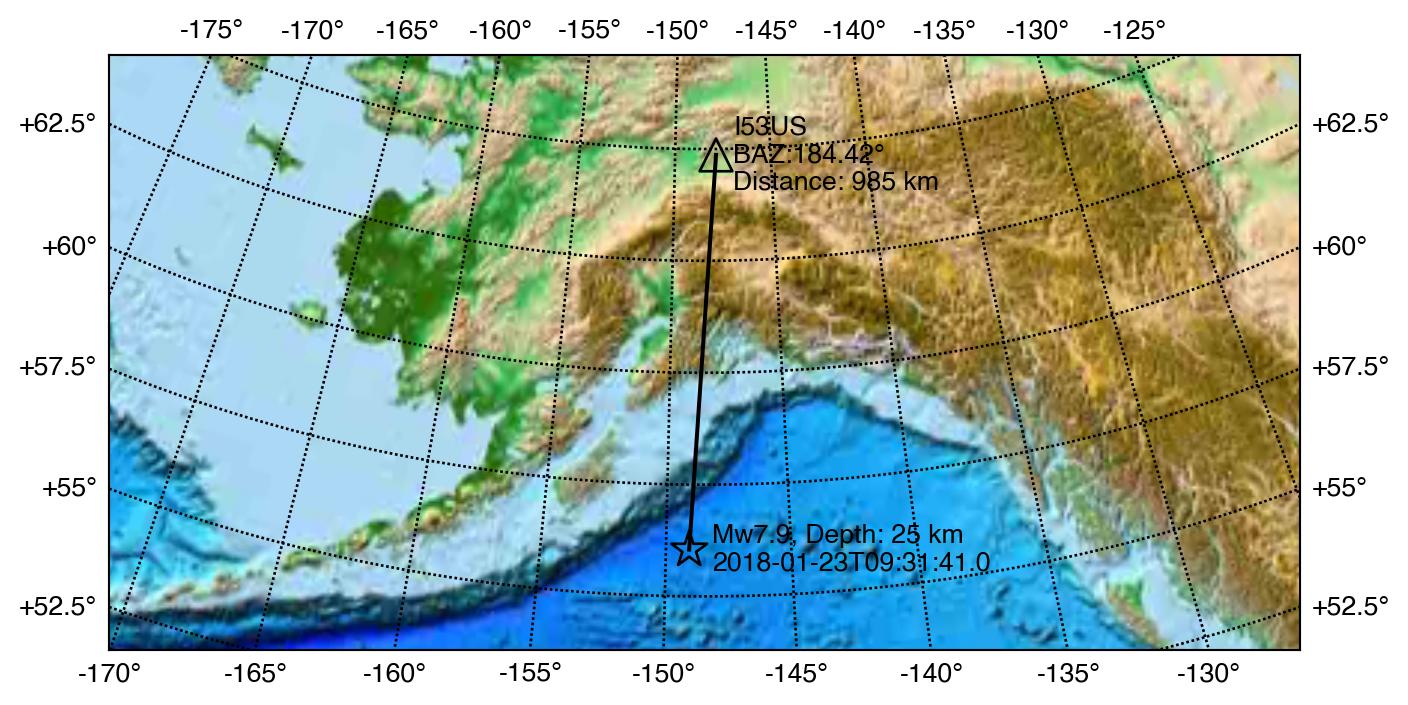

In [12]:
bb = BestBeam('data/IM.I53US.jtdfd')
fig, ax, m = bb.plot_map(wfactor=2, parallels_every=2.5)

(<Figure size 672x672 with 5 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x11f0e0da0>,
       dtype=object))

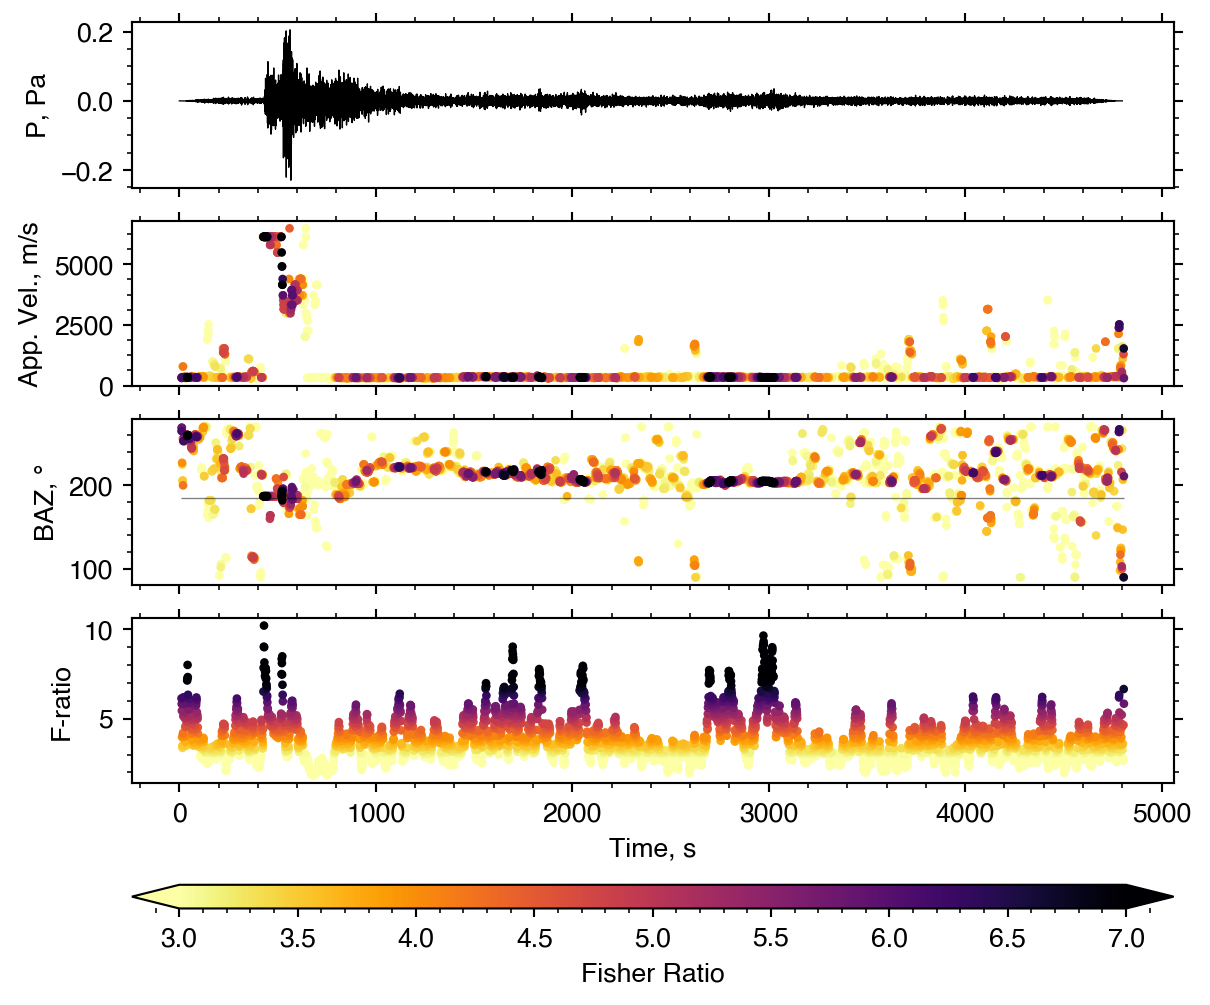

In [13]:
bb = BestBeam('data/IM.I53US.jtdfd')
bb.plot_data(vmin=3, vmax=7)